In [82]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
# loading the dataset
file_path = 'Steel_industry_data.csv'
data = pd.read_csv(file_path)

# displaying the first few features of the dataset and also to understand the structure of the dataset
print(data.head())
print("\n",data.columns.tolist())

               date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   
3  01/01/2018 01:00       3.31                                  3.56   
4  01/01/2018 01:15       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                         100.0   900   
1                         66.77                         100.0  1800   
2                         70.

Attribute Information:

Date Continuous - time data taken on the first of the month

Usage_kWh - Industry Energy Consumption Continuous kWh

Lagging Current - reactive power Continuous kVarh

Leading Current - reactive power Continuous kVarh

CO2 - Continuous ppm

NSM - Number of Seconds from midnight Continuous S

Week - status Categorical (Weekend (0) or a Weekday(1))

Day of week - Categorical Sunday, Monday : Saturday

Load Type - Categorical Light Load, Medium Load, Maximum Load



Dependent Variable (Target): Usage_kWh

Independent Variables (Features):

Lagging_Current_Reactive.Power_kVarh

Leading_Current_Reactive_Power_kVarh

CO2(tCO2)

Lagging_Current_Power_Factor

Leading_Current_Power_Factor

NSM

WeekStatus (Encoded)

Day_of_week (Encoded)

Load_Type (Encoded)

In [75]:
# To find the total number of records in the dataset
total_records = data.shape[0]
total_records

35040

In [76]:
# initially categorize based on the type of the data
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# then we categorize based on unique values and content
binary_cols = [col for col in data.columns if data[col].nunique() == 2]
nominal_cols = ['Day_of_week']  # Based on prior knowledge of the data
categorical_cols = ['WeekStatus', 'Load_Type']  # Encoded but originally categorical
remaining_numerical = [col for col in numerical_cols if col not in binary_cols]
datetime_cols = data.select_dtypes(include=['datetime']).columns.tolist()

categorization = {
    "Binary": binary_cols,
    "Nominal": nominal_cols,
    "Categorical": categorical_cols,
    "Numerical": remaining_numerical,
    "Datetime": datetime_cols
}

# Convert the categorization dictionary to a DataFrame for display as a table
categorization_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in categorization.items()]))

categorization_df

/var/folders/lp/655j5rwx7ll2f988h2p8nw580000gn/T/ipykernel_1987/3964872346.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categorization_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in categorization.items()]))


,Binary,Nominal,Categorical,Numerical,Datetime
0,WeekStatus,Day_of_week,WeekStatus,Usage_kWh,NaN
1,NaN,NaN,Load_Type,Lagging_Current_Reactive.Power_kVarh,NaN
2,NaN,NaN,NaN,Leading_Current_Reactive_Power_kVarh,NaN
3,NaN,NaN,NaN,CO2(tCO2),NaN
4,NaN,NaN,NaN,Lagging_Current_Power_Factor,NaN
5,NaN,NaN,NaN,Leading_Current_Power_Factor,NaN
6,NaN,NaN,NaN,NSM,NaN


In [77]:
#let's convert the categorization dictionary to pair each feature with its categorized data type
features_and_types = []
for k, v in categorization.items():
    for i in v:
        if pd.notnull(i):
            features_and_types.append((i, k))

features_types_df_no_nan = pd.DataFrame(features_and_types_corrected, columns=['Feature Name', 'Data Type Categorized'])

features_types_df_no_nan


,Feature Name,Data Type Categorized
0,WeekStatus,Binary
1,Day_of_week,Nominal
2,WeekStatus,Categorical
3,Load_Type,Categorical
4,Usage_kWh,Numerical
5,Lagging_Current_Reactive.Power_kVarh,Numerical
6,Leading_Current_Reactive_Power_kVarh,Numerical
7,CO2(tCO2),Numerical
8,Lagging_Current_Power_Factor,Numerical
9,Leading_Current_Power_Factor,Numerical


In [78]:
summary_statistics = data.describe()
summary_statistics

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [79]:
# Check for missing values
missing_values = data.isnull().sum()

# Calculate the proportion of missing values
total_cells = np.product(data.shape)
total_missing = missing_values.sum()
proportion_missing = total_missing / total_cells

print(f"Number of missing values: {total_missing}")
print(f"Proportion of missing values: {proportion_missing:.2%}")

Number of missing values: 0
Proportion of missing values: 0.00%


In [80]:
# Example: Detect outliers using IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Define bounds for what is considered an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = ((data < lower_bound) | (data > upper_bound)).sum()

/var/folders/lp/655j5rwx7ll2f988h2p8nw580000gn/T/ipykernel_1987/956377361.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((data < lower_bound) | (data > upper_bound)).sum()


In [81]:
outliers

CO2(tCO2)                                437
Day_of_week                                0
Lagging_Current_Power_Factor               1
Lagging_Current_Reactive.Power_kVarh    1059
Leading_Current_Power_Factor            8327
Leading_Current_Reactive_Power_kVarh    7759
Load_Type                                  0
NSM                                        0
Usage_kWh                                328
WeekStatus                                 0
date                                       0
dtype: int64

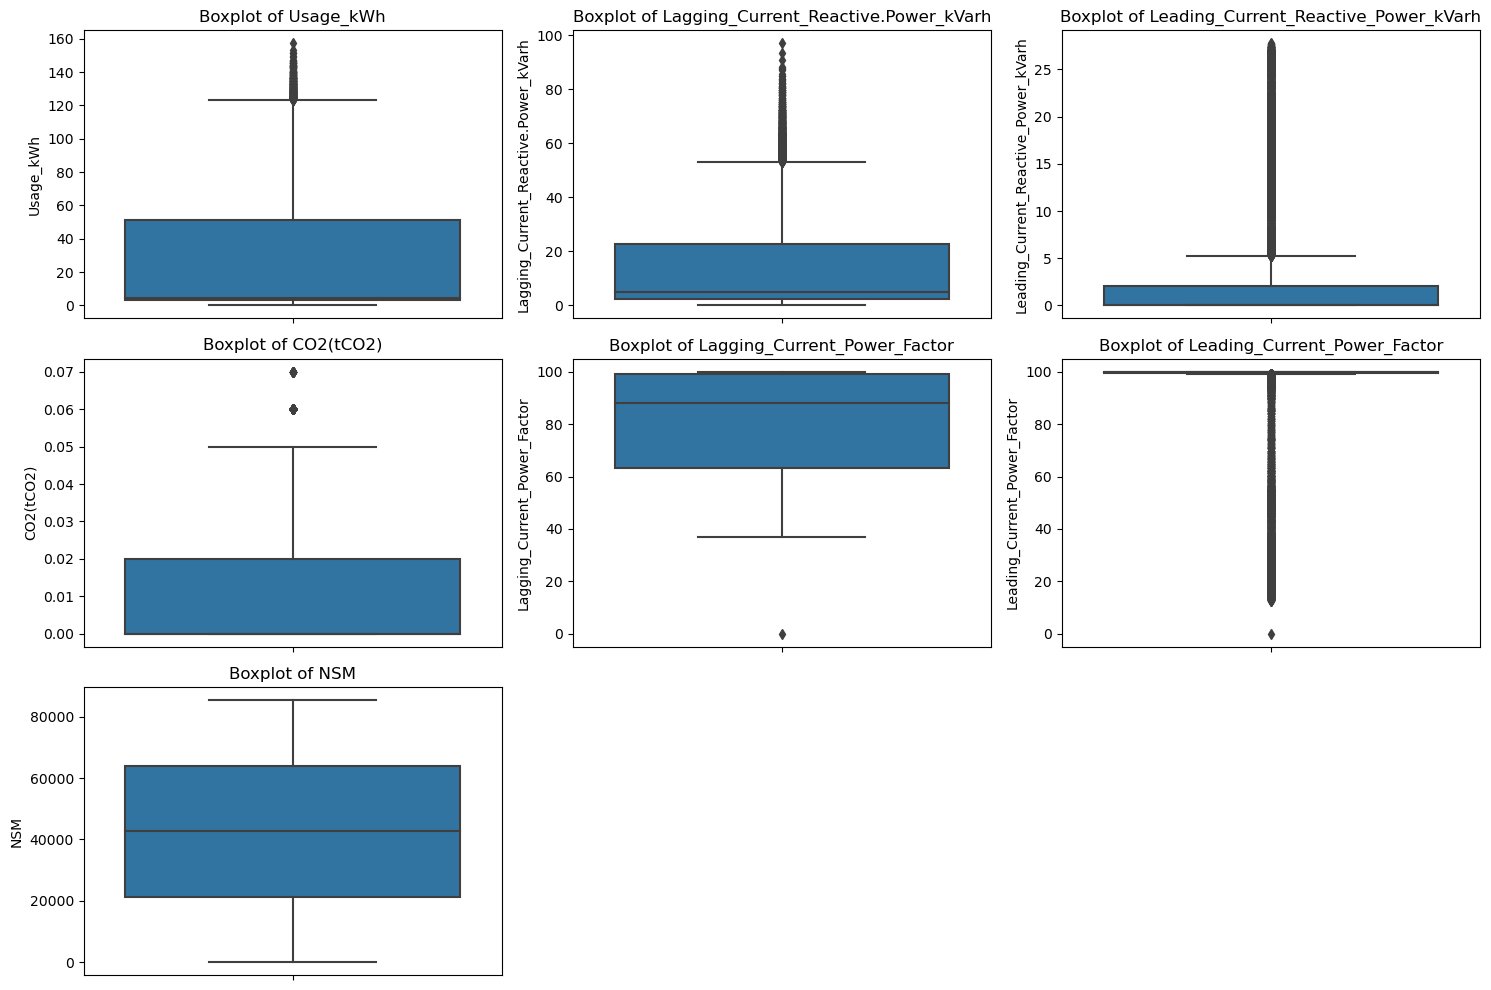

In [83]:
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Plot boxplots for each column
plt.figure(figsize=(15, 10))  # Adjust the size as needed
for i, col in enumerate(numerical_data.columns):
    plt.subplot(len(numerical_data.columns) // 3 + 1, 3, i + 1)
    sns.boxplot(y=col, data=numerical_data)
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

In [86]:
# Capping at the 1st and 99th percentiles
for col in ['Usage_kWh', 'CO2(tCO2)']:
    lower_percentile = data[col].quantile(0.01)
    upper_percentile = data[col].quantile(0.99)
    data[col] = np.clip(data[col], lower_percentile, upper_percentile)

# Ensuring NSM is within the range 0 to 86400 (number of seconds in 24 hours)
data['NSM'] = np.clip(data['NSM'], 0, 86400)

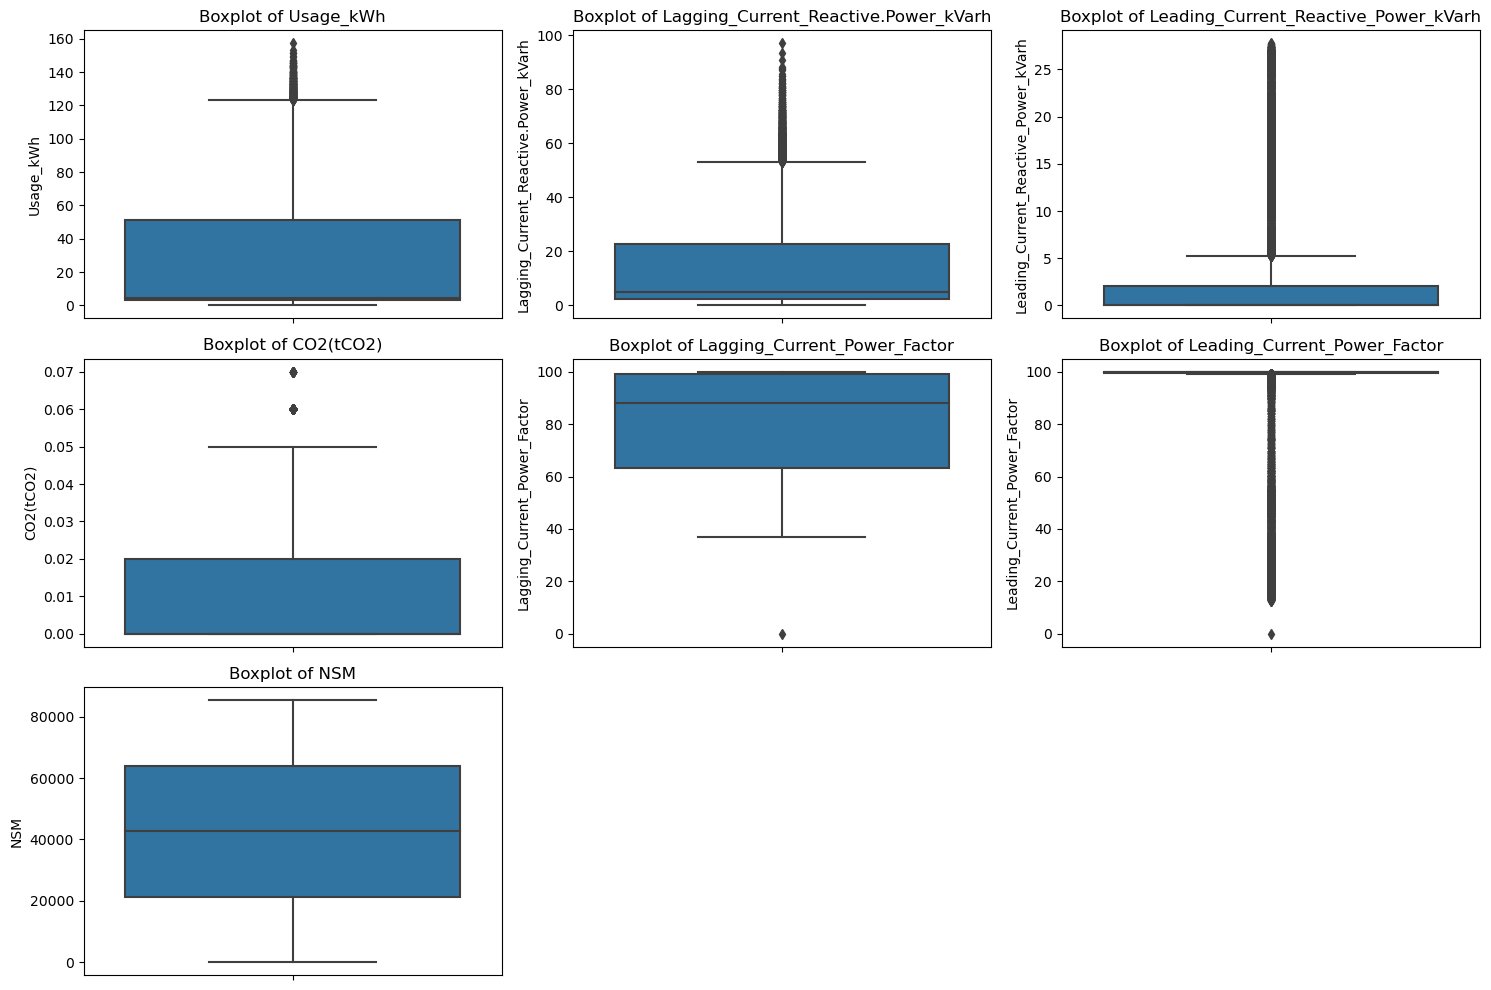

In [87]:
plt.figure(figsize=(15, 10))  # Adjust the size as needed
for i, col in enumerate(numerical_data.columns):
    plt.subplot(len(numerical_data.columns) // 3 + 1, 3, i + 1)
    sns.boxplot(y=col, data=numerical_data)
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

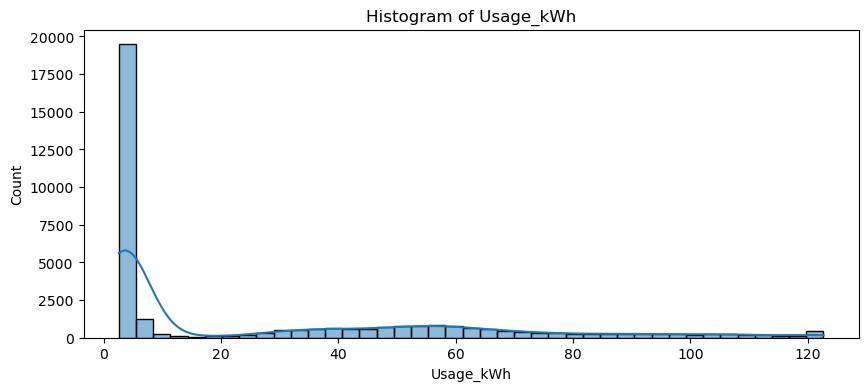

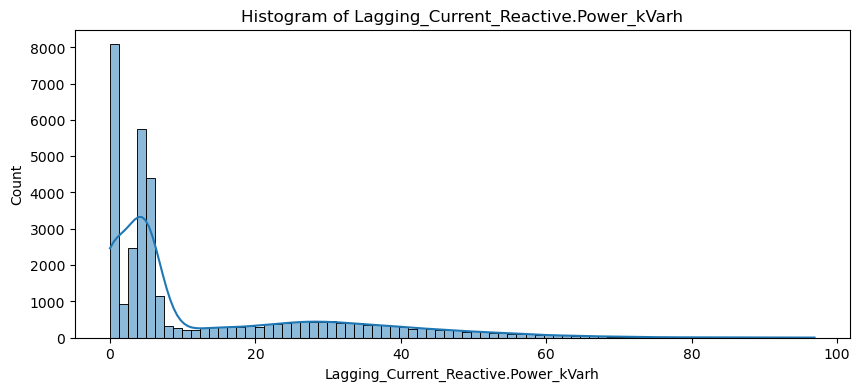

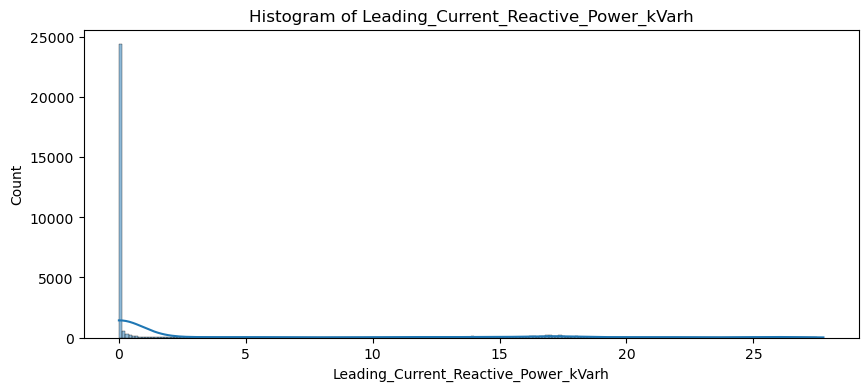

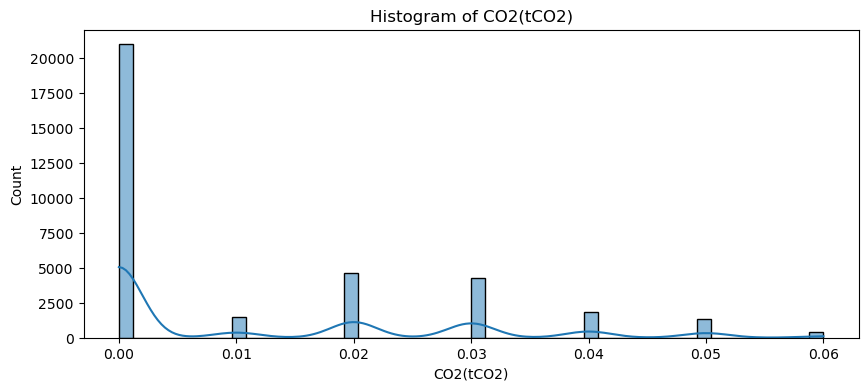

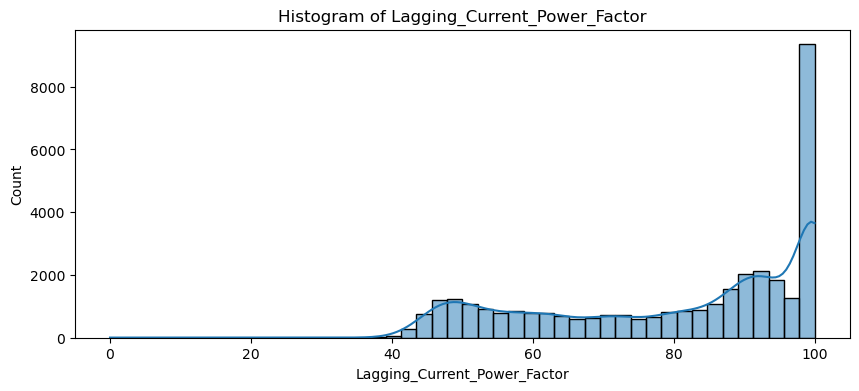

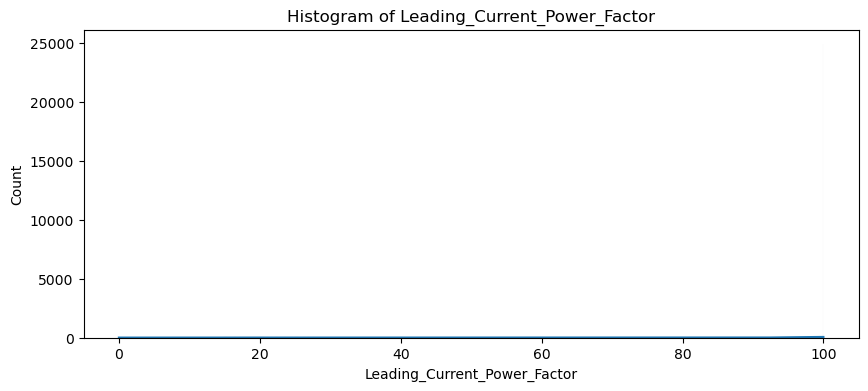

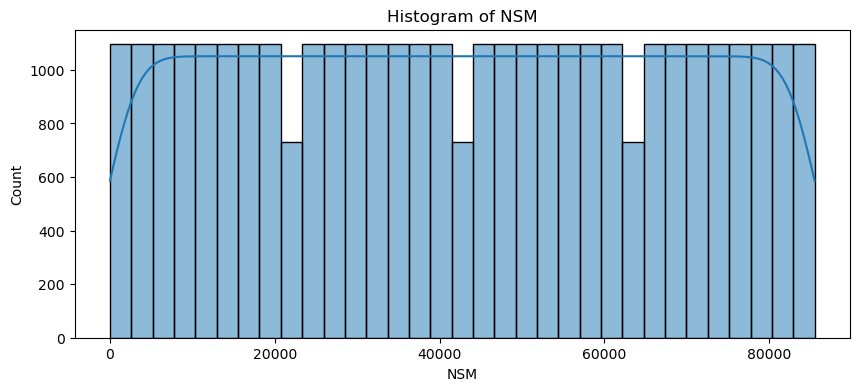

Positivity check (all values are >= 0):
Usage_kWh                               True
Lagging_Current_Reactive.Power_kVarh    True
Leading_Current_Reactive_Power_kVarh    True
CO2(tCO2)                               True
Lagging_Current_Power_Factor            True
Leading_Current_Power_Factor            True
NSM                                     True
dtype: bool

Skewness of numeric columns:
Usage_kWh                               1.161411
Lagging_Current_Reactive.Power_kVarh    1.437899
Leading_Current_Reactive_Power_kVarh    1.734314
CO2(tCO2)                               1.140444
Lagging_Current_Power_Factor           -0.606126
Leading_Current_Power_Factor           -1.511984
NSM                                     0.000000
dtype: float64


In [89]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])
positivity = (numeric_data >= 0).all()
skewness = numeric_data.skew()

# Create histograms to visually assess skewness for each numeric column
for col in numeric_data.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(numeric_data[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()

# Print the results
print(f"Positivity check (all values are >= 0):\n{positivity}\n")
print(f"Skewness of numeric columns:\n{skewness}")

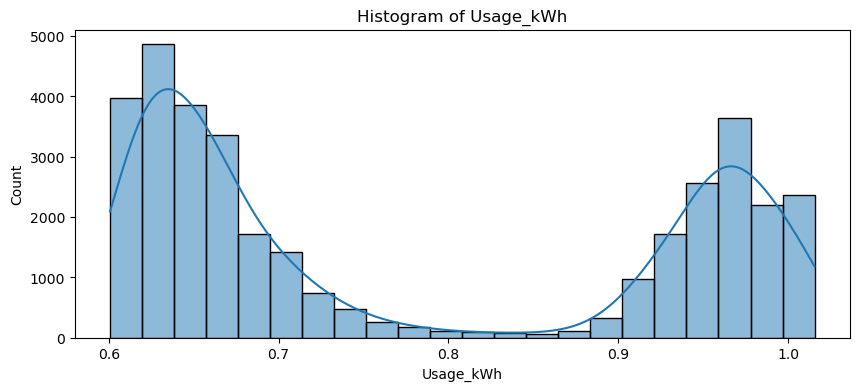

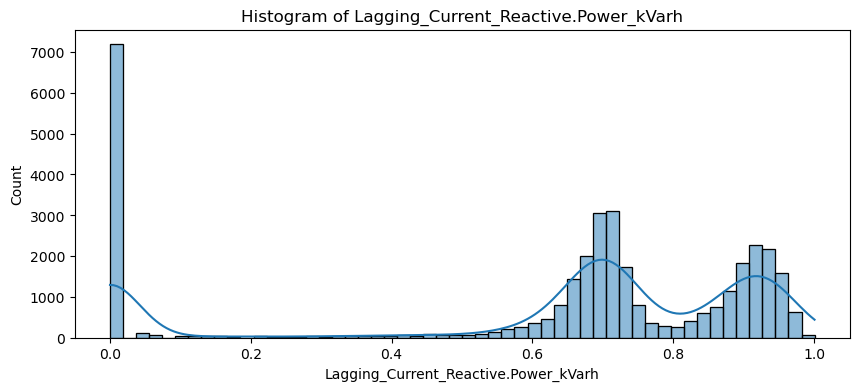

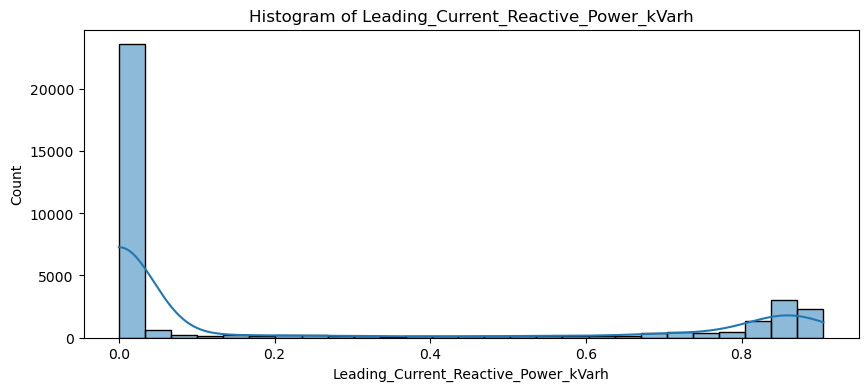

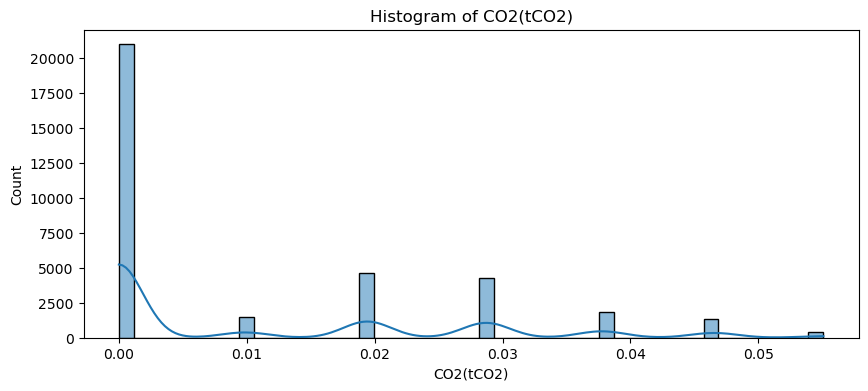

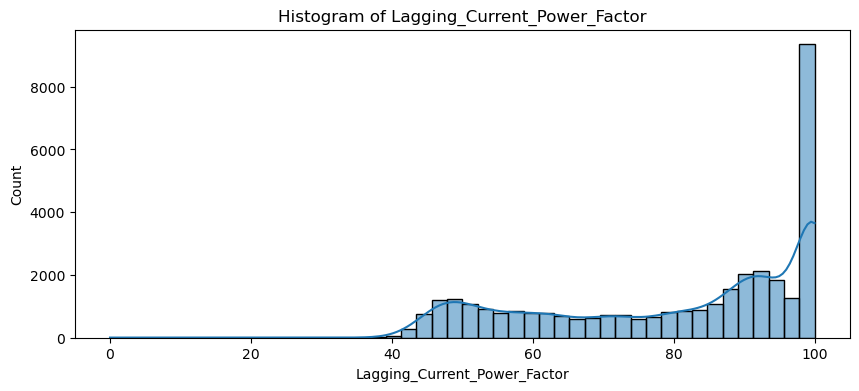

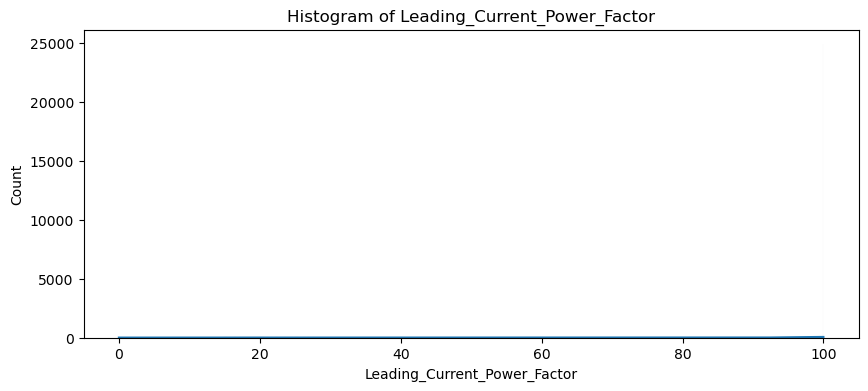

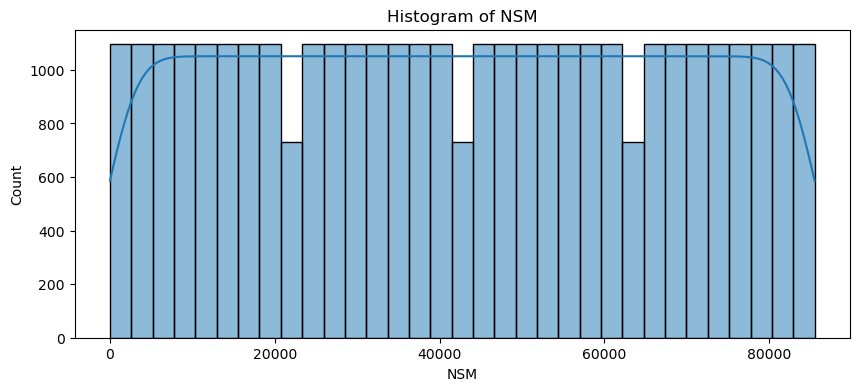

Positivity check (all values are >= 0):
Usage_kWh                               True
Lagging_Current_Reactive.Power_kVarh    True
Leading_Current_Reactive_Power_kVarh    True
CO2(tCO2)                               True
Lagging_Current_Power_Factor            True
Leading_Current_Power_Factor            True
NSM                                     True
dtype: bool

Skewness of numeric columns:
Usage_kWh                               0.351694
Lagging_Current_Reactive.Power_kVarh   -0.990757
Leading_Current_Reactive_Power_kVarh    1.081103
CO2(tCO2)                               1.082919
Lagging_Current_Power_Factor           -0.606126
Leading_Current_Power_Factor           -1.511984
NSM                                     0.000000
dtype: float64


In [92]:
data['Usage_kWh'] = np.log1p(data['Usage_kWh'])
data['Lagging_Current_Reactive.Power_kVarh'] = np.log1p(data['Lagging_Current_Reactive.Power_kVarh'])
data['Leading_Current_Reactive_Power_kVarh'] = np.log1p(data['Leading_Current_Reactive_Power_kVarh'])
data['CO2(tCO2)'] = np.log1p(data['CO2(tCO2)'])

numeric_data = data.select_dtypes(include=['float64', 'int64'])
positivity = (numeric_data >= 0).all()
skewness = numeric_data.skew()

# Create histograms to visually assess skewness for each numeric column
for col in numeric_data.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(numeric_data[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()

# Print the results
print(f"Positivity check (all values are >= 0):\n{positivity}\n")
print(f"Skewness of numeric columns:\n{skewness}")

Low               4643
Moderate          4261
High              1834
Very Low          1512
Very High         1363
Extremely High     437
Name: CO2(tCO2)_binned, dtype: int64


/Users/yeshwanthkotha/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


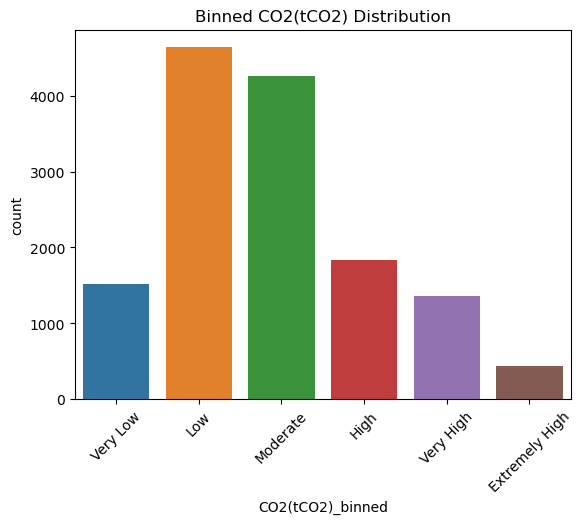

In [93]:
# Define bins for CO2 levels based on the histogram spikes or domain knowledge
bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05, np.inf]

# Create bin labels
bin_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Extremely High']

# Bin the CO2 data
data['CO2(tCO2)_binned'] = pd.cut(data['CO2(tCO2)'], bins=bins, labels=bin_labels)
co2_binned_counts = data['CO2(tCO2)_binned'].value_counts()

# Print the distribution of the binned data
print(co2_binned_counts)
sns.countplot(data['CO2(tCO2)_binned'])
plt.title('Binned CO2(tCO2) Distribution')
plt.xticks(rotation=45) 
plt.show()


In [ ]:
# saviing the preprocessed dataframe into a .csv file so we can easily process from this step in future
data.to_csv('cleaned_&_processed_dataset.csv', index=False)

In [ ]:
# Encode categorical variables
le = LabelEncoder()
data['WeekStatus'] = le.fit_transform(data['WeekStatus'])
data['Day_of_week'] = le.fit_transform(data['Day_of_week'])
data['Load_Type'] = le.fit_transform(data['Load_Type'])

''' Independent variables (exclude 'date' and 'Usage_kWh') 
we are removing date because it's a timestamp, 
and its direct numerical value might not provide meaningful 
information without further feature engineering 
(e.g., extracting day of the week, hour of the day, etc., 
which you already have in some form). '''

X = data.drop(['date', 'Usage_kWh'], axis=1)

# Dependent variable
y = data['Usage_kWh']

# Splitting dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


Low Variance Filter: Remove variables with little to no variance, as they don't contribute much information.

In [ ]:
# we are making sure there are no non-numeric columns in dataset by performing below operation
X_numeric = data.select_dtypes(include=['float64', 'int64'])
X_non_numeric = data.select_dtypes(exclude=['float64', 'int64'])

# Now 'X_numeric' contains only numeric features, you can proceed with VarianceThreshold
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_reduced = selector.fit_transform(X_numeric)

# Features selected
features_selected = X_numeric.columns[selector.get_support(indices=True)]
features_removed_variance = list(set(X_numeric.columns) - set(features_selected))

print("Features selected by variance threshold:", features_selected)
print("Features removed due to low variance:", features_removed_variance)

X = pd.concat([data[features_selected], X_non_numeric], axis=1)


In [ ]:
print("Updated features in 'X':", X.columns.tolist())


In [ ]:
# Identify and count duplicates
duplicates = X.duplicated()
num_duplicates = duplicates.sum()

# Remove duplicates from X and keep the indices
X_clean = X.loc[~duplicates]

# Use the same indices to keep corresponding rows in y
y_clean = y.loc[X_clean.index]

# Calculate the proportion of duplicates removed
proportion_duplicates_removed = num_duplicates / len(X)

print(f"Number of duplicate rows removed: {num_duplicates}")
print(f"Proportion of duplicate rows removed: {proportion_duplicates_removed:.2%}")

X = X_clean
y = y_clean


In [ ]:
X['date'] = (X['date'] - X['date'].min()).dt.days
X = X.drop('date', axis=1)

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to keep 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Interpret the results
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
n_components = len(pca.explained_variance_ratio_)

# Print the results
print(f"Explained variance by each component: {explained_variance}")
print(f"Cumulative explained variance: {cumulative_variance}")
print(f"Number of components to retain 95% of variance: {n_components}")

In [ ]:
# Create a DataFrame with the PCA components
X_pca_df = pd.DataFrame(X_pca, columns=[f'PCA_Component_{i}' for i in range(1, n_components+1)])

# Assign the index from the original DataFrame to ensure alignment
X_pca_df.index = X.index

# Combine the PCA components with the target variable 'y'
combined_df = pd.concat([X_pca_df, y], axis=1)

# Save the combined DataFrame to a CSV file, including the index
combined_df.to_csv('preprocessed_data_with_pca_and_target.csv', index=True)
